In [16]:
import pickle
import matplotlib.pyplot as plt
import pandas
import numpy as np
import os 
import tensorflow 
import sklearn.metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization
from keras.utils import np_utils
from skimage import io 
from PIL import Image
import cv2
from sklearn.preprocessing import MinMaxScaler
from skimage import data, img_as_float
from skimage import exposure
import colorsys
import seaborn as sns


prop_cycle = plt.rcParams['axes.prop_cycle']
COLOR_CYCLE = prop_cycle.by_key()['color']

# history plotter class found at https://github.com/tensorflow/docs/blob/master/tools/tensorflow_docs/plots/__init__.py
class HistoryPlotter(object):
    def __init__(self, metric=None, smoothing_std=None):
        self.color_table = {}
        self.metric = metric
        self.smoothing_std = smoothing_std
        
    def _smooth(values, std):
        # Smooths a list of values by convolving with a gaussian.
        width = std * 4
        x = np.linspace(-width, width, 2 * width + 1)
        kernel = np.exp(-(x / 5)**2)

        values = np.array(values)
        weights = np.ones_like(values)

        smoothed_values = np.convolve(values, kernel, mode='same')
        smoothed_weights = np.convolve(weights, kernel, mode='same')

        return smoothed_values / smoothed_weights

    def plot(self, histories, metric=None, smoothing_std=None):
        if metric is None:
            metric = self.metric
        if smoothing_std is None:
            smoothing_std = self.smoothing_std

        for name, history in histories.items():
          # Remember name->color asociations.
            if name in self.color_table:
                color = self.color_table[name]
            else:
                color = COLOR_CYCLE[len(self.color_table) % len(COLOR_CYCLE)]
                self.color_table[name] = color

            train_value = history.history[metric]
            val_value = history.history['val_' + metric]
            if smoothing_std is not None:
                train_value = _smooth(train_value, std=smoothing_std)
                val_value = _smooth(val_value, std=smoothing_std)

            plt.plot(
                history.epoch,
                train_value,
                color=color,
                label=name.title() + ' Train')
            plt.plot(
                history.epoch,
                val_value,
                '--',
                label=name.title() + ' Val',
                color=color)

        plt.xlabel('Epochs')
        plt.ylabel(metric.replace('_', ' ').title())
        plt.legend()

        plt.xlim(
            [0, max([history.epoch[-1] for name, history in histories.items()])])
        plt.grid(True)

In [17]:
# image augmentation to increase dataset's size
datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(featurewise_center=False,
                                             samplewise_center=False,
                                             featurewise_std_normalization=False,
                                             samplewise_std_normalization=False, 
                                             zca_whitening=False,
                                             zca_epsilon=1e-06,
                                             rotation_range=45,
                                             brightness_range=None, 
                                             shear_range=False, 
                                             zoom_range=0.5, 
                                             channel_shift_range=0.0, 
                                             fill_mode='nearest', 
                                             cval=0.0, 
                                             horizontal_flip=True, 
                                             vertical_flip=False, 
                                             data_format='channels_last', 
                                             dtype='float32')
testgen = tensorflow.keras.preprocessing.image.ImageDataGenerator()        

In [11]:
# read original dataset 
path_no='complete_mednode_dataset\\naevus'
path_yes='complete_mednode_dataset\\melanoma'
rgb_can_im_list=[]
rgb_heal_im_list=[]
paths=[path_yes,path_no]
names=[]
for path in paths:
    for name in os.walk(path):
        names.append(name[2])
    
cancer=names[0]
healthy=names[1]
    
for image in cancer:
    rgb_can_im_list.append(np.array(Image.open(os.path.join(path_yes, image), 'r').resize((224,224)))/255)

for image in healthy:
    rgb_heal_im_list.append(np.array(Image.open(os.path.join(path_no, image), 'r').resize((224,224)))/255)

# read processed images from pickle file
with open('dataMelanoma.pickle', 'rb') as f:
    dataMelanoma = pickle.load(f)
    
rescaled_can_im_list=np.array(dataMelanoma['rescaled_can_im_list'])
eq_can_im_list=np.array(dataMelanoma['eq_can_im_list'])
adapteq_can_im_list=np.array(dataMelanoma['adapteq_can_im_list'])

rescaled_heal_im_list=np.array(dataMelanoma['rescaled_heal_im_list'])
eq_heal_im_list=np.array(dataMelanoma['eq_heal_im_list'])
adapteq_heal_im_list=np.array(dataMelanoma['adapteq_heal_im_list'])

# gather images
health = [rgb_heal_im_list, rescaled_heal_im_list, eq_heal_im_list, adapteq_heal_im_list]
cancer = [rgb_can_im_list, rescaled_can_im_list, eq_can_im_list, adapteq_can_im_list]

names = ['rgb','contrast stretching','histogramm equalization','adapted histogramm equalization']
history = {}

---------------------------------------------  rgb  ------------------------------------------------------
rgb
Accuracy: 70.00%


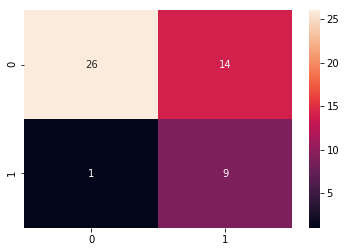

---------------------------------------------  contrast stretching  ------------------------------------------------------
contrast stretching
Accuracy: 80.00%


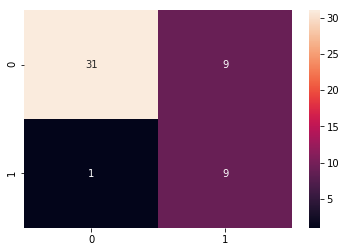

---------------------------------------------  histogramm equalization  ------------------------------------------------------
histogramm equalization
Accuracy: 74.00%


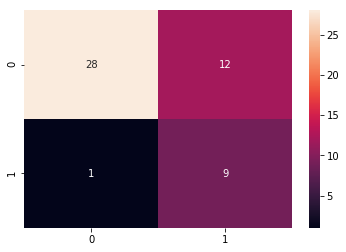

---------------------------------------------  adapted histogramm equalization  ------------------------------------------------------
adapted histogramm equalization
Accuracy: 72.00%


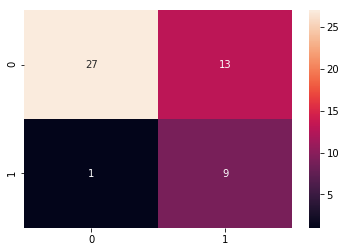

In [12]:
# model training and evaluation for each image category (rgb, contrast stretching, histogramm equalization, adapted histogramm equalization)   
for p in range(4):
    can_images=cancer[p]
    heal_images=health[p]
    name = names[p]
    # assign labels to images (naevus=0, melanoma=1), split dataset in train and test 
    split_number=60
    can_labels_train=np.ones(split_number)
    heal_labels_train=np.zeros(split_number)

    can_labels_pred=[1]*(70-split_number)
    heal_labels_pred=[0]*(100-split_number)

    data_train=np.concatenate((can_images[:split_number],heal_images[:split_number]))
    classes_train=np.concatenate((can_labels_train,heal_labels_train))

    x_pred=np.concatenate((can_images[split_number:70],heal_images[split_number:100]))
    y_pred=np.concatenate((can_labels_pred,heal_labels_pred))
    
    # shuffle train dataset
    idx = np.random.permutation(2*split_number)
    x_train=[]
    y_train=[]
    for i in idx:
        x_train.append(data_train[i])
        y_train.append(classes_train[i])
    x_train=np.array(x_train)
    y_train=np.array(y_train)
    
    # create CNN model
    classifier = Sequential()
    classifier.add(Conv2D(16, (3, 3), input_shape=(224, 224, 3), padding='same',activation='relu'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    classifier.add(Conv2D(32, (3, 3), padding='same',activation='relu'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))    
    classifier.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(units=32, activation='relu'))
    classifier.add(Dropout(0.2))
    classifier.add(Dense(units=1, activation='sigmoid'))
    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Fit the model 1
    historydw=classifier.fit_generator(datagen.flow(x_train,y_train),validation_data=testgen.flow(x_pred,y_pred),epochs=100,verbose=0) 
    history[f"{name}"] = historydw
    # Final evaluation of the model
    scores = classifier.evaluate(x_pred, y_pred, verbose=0)
    print('--------------------------------------------- ',name," ------------------------------------------------------")
    print(name)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    # Make predictions
    predictions = classifier.predict(x_pred)
    predictions_the_sequel = []
    for item in predictions:
        if item<0.5:
            predictions_the_sequel.append(0)
        else:
            predictions_the_sequel.append(1)
    # Create confusion matrix
    sns.heatmap(sklearn.metrics.confusion_matrix(y_pred, predictions_the_sequel),annot=True)
    plt.show()

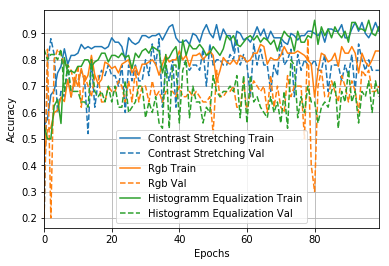

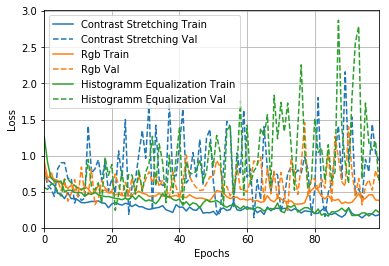

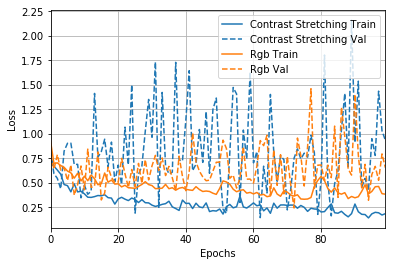

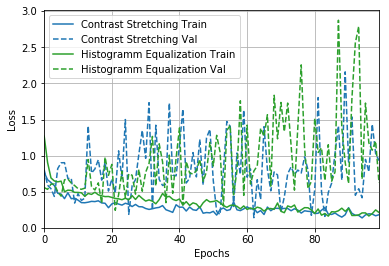

In [8]:
#plot metrics
plotter = HistoryPlotter()
plotter.plot({'contrast stretching':history['contrast stretching'],'rgb':history['rgb'],'histogramm equalization':history['histogramm equalization']}, metric='accuracy')
plt.show()
plotter.plot({'contrast stretching':history['contrast stretching'],'rgb':history['rgb'],'histogramm equalization':history['histogramm equalization']}, metric='loss')
plt.show()
plotter.plot({'contrast stretching':history['contrast stretching'],'rgb':history['rgb']}, metric='loss')
plt.show()
plotter.plot({'contrast stretching':history['contrast stretching'],'histogramm equalization':history['histogramm equalization']}, metric='loss')